### В данной части решается задача бинарной классификации -> закрыты или открыты глаза

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2

### 1. Создадим обучающий датасет

In [2]:
path_train_open = './archive/dataset_new/train/Open/'  # лежат фото открытых глаз
path_train_closed = './archive/dataset_new/train/Closed/' # лежат фото закрытых глаз

***сформируем список train_open из фотографий с открытыми глазами<br>
cформируем список train_closed из фотографий с закрытыми глазами***

In [3]:
def get_files(path):
    import os
    list_of_files = []
    for root, dirs, files in os.walk(path):
        path = root.split(os.sep)
        for file in files:
            if file[-3:] == 'jpg':
                list_of_files.append(root + file)
    return list_of_files
    


train_files_open = get_files(path_train_open)
train_files_closed = get_files(path_train_closed)
            
print(train_files_closed[:3])
print(train_files_closed[:3])

['./archive/dataset_new/train/Closed/_0.jpg', './archive/dataset_new/train/Closed/_1.jpg', './archive/dataset_new/train/Closed/_10.jpg']
['./archive/dataset_new/train/Closed/_0.jpg', './archive/dataset_new/train/Closed/_1.jpg', './archive/dataset_new/train/Closed/_10.jpg']


***Посмотрим на конкретное изображение***

(175, 175, 3)
(145, 145, 3)


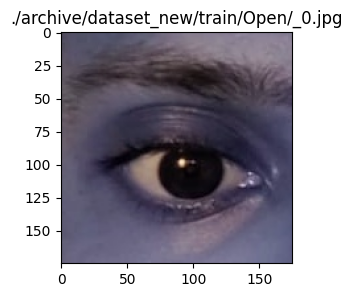

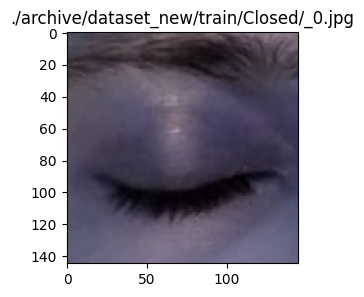

In [4]:
def show_image(path):
    img = cv2.imread(path, cv2.COLOR_BGR2RGB) #загружаем изображение
    plt.figure(figsize=(3,3))
    plt.imshow(img, label=path)
    plt.title(path)
    print(img.shape)
    
show_image(train_files_open[0])
show_image(train_files_closed[0])

***Загрузим все фотографии обучающей выборки, это мы сделать можем, так как они весят немного<br>***
Каждое изображение имеет различный размер, что не подходит для обучения сети, поэтому при загрузке <br>
принудительно изменим размер изображения на 50 x 50

In [5]:
IMG_SIZE = (100, 100)

In [6]:
def make_dataset(files_open, files_closed, IMG_SIZE):
    import random
    
    list_of_imgs = []
    y = []
    all_files = files_open + files_closed
    
    random.shuffle(all_files)

    for file in all_files:
        img = cv2.imread(file, cv2.COLOR_BGR2RGB)  # загрузка изображения
        img = cv2.resize(img, IMG_SIZE) # изменение размера
        img = img / 255  # нормализация
        list_of_imgs.append(img)
        
        if file.split('/')[-2] == 'Open': # определение метки класса -> Open = 1, Closed = 0
            y.append(1)
        else:
            y.append(0)
    
    return [list_of_imgs, y]
        
train_data = make_dataset(train_files_open, train_files_closed, IMG_SIZE)

 ***итоговая структура train_data:<br>***
 

1
[[[0.49411765 0.59607843 0.71372549]
  [0.49019608 0.58823529 0.71372549]
  [0.49411765 0.59215686 0.7254902 ]
  ...
  [0.18823529 0.25882353 0.30196078]
  [0.19215686 0.2627451  0.30588235]
  [0.16470588 0.23137255 0.26666667]]

 [[0.49803922 0.59607843 0.72156863]
  [0.50196078 0.6        0.7254902 ]
  [0.49803922 0.59607843 0.72941176]
  ...
  [0.18039216 0.25098039 0.29411765]
  [0.16862745 0.23921569 0.28235294]
  [0.17254902 0.23921569 0.2745098 ]]

 [[0.50588235 0.60392157 0.7372549 ]
  [0.51372549 0.61176471 0.74509804]
  [0.50588235 0.60392157 0.72941176]
  ...
  [0.19215686 0.2627451  0.30588235]
  [0.2        0.27058824 0.31372549]
  [0.18431373 0.25098039 0.28627451]]

 ...

 [[0.54901961 0.64705882 0.80392157]
  [0.51764706 0.61960784 0.77647059]
  [0.49411765 0.59215686 0.75686275]
  ...
  [0.31372549 0.41176471 0.54509804]
  [0.29411765 0.39215686 0.5254902 ]
  [0.30196078 0.4        0.53333333]]

 [[0.55686275 0.65490196 0.81176471]
  [0.5254902  0.62745098 0.78431373

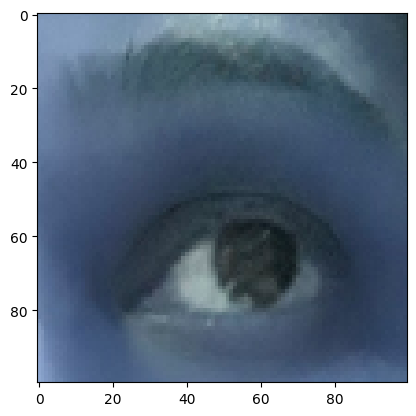

In [7]:
# train_data[0] - список всех train изображеиний, как с открытыми, так и закрытыми глазами
# train_data[1] - список всех меток класса, Open = 1, Closed = 0

print(train_data[1][4]) # метка класса
print(train_data[0][4]) # 5е изображение

plt.figure()
plt.imshow(train_data[0][4])

### 2. Аналогично загрузим тестовый датасет

In [8]:
path_test_open = './archive/dataset_new/test/Open/'  # лежат фото открытых глаз
path_test_closed = './archive/dataset_new/test/Closed/' # лежат фото закрытых гла

test_files_open = get_files(path_test_open)
test_files_closed = get_files(path_test_closed)
            
print(test_files_closed[:3])
print(test_files_closed[:3])
        
test_data = make_dataset(test_files_open, test_files_closed, IMG_SIZE)

['./archive/dataset_new/test/Closed/_107.jpg', './archive/dataset_new/test/Closed/_115.jpg', './archive/dataset_new/test/Closed/_116.jpg']
['./archive/dataset_new/test/Closed/_107.jpg', './archive/dataset_new/test/Closed/_115.jpg', './archive/dataset_new/test/Closed/_116.jpg']


### 3. Создадим модель нейросети

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

def get_model():
    keras.backend.clear_session()
    model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE[0],IMG_SIZE[1], 3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
#     Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
#     Dropout(0.5),
    Dense(2, activation='softmax')])
    return model
    
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0

***Настройки обучения***

In [10]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Путь к весам при обучении для логирования (логируется каждая эпоха)
checkpoint_path = "./Models_weights/Adam_{epoch:04d}_{accuracy:.04f}_{loss:.04f}_{val_loss:.04f}.h5"
last_finished_epoch = None

***Обучение***

In [11]:
history = model.fit(
    x=np.asarray(train_data[0]),
    y=np.asarray(train_data[1]),
    batch_size=128,
    epochs=30,
    callbacks=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 monitor='val_accuracy',
                                                 mode='min',
                                                 save_best_only=False,
                                                 save_freq='epoch',
                                                 save_weights_only=True),
    validation_data=(np.asarray(test_data[0]), np.asarray(test_data[1])),
    verbose=1,
    initial_epoch=0
)

Epoch 1/30
10/10 [==============================] - 3s 83ms/step - loss: 0.6783 - accuracy: 0.5827 - val_loss: 0.5419 - val_accuracy: 0.8165
Epoch 2/30
10/10 [==============================] - 0s 34ms/step - loss: 0.3993 - accuracy: 0.8493 - val_loss: 0.2025 - val_accuracy: 0.9312
Epoch 3/30
10/10 [==============================] - 0s 33ms/step - loss: 0.2115 - accuracy: 0.9117 - val_loss: 0.1638 - val_accuracy: 0.9404
Epoch 4/30
10/10 [==============================] - 0s 33ms/step - loss: 0.1523 - accuracy: 0.9498 - val_loss: 0.1815 - val_accuracy: 0.9404
Epoch 5/30
10/10 [==============================] - 0s 35ms/step - loss: 0.1236 - accuracy: 0.9554 - val_loss: 0.1349 - val_accuracy: 0.9633
Epoch 6/30
10/10 [==============================] - 0s 34ms/step - loss: 0.0920 - accuracy: 0.9668 - val_loss: 0.1242 - val_accuracy: 0.9587
Epoch 7/30
10/10 [==============================] - 0s 33ms/step - loss: 0.0742 - accuracy: 0.9724 - val_loss: 0.1080 - val_accuracy: 0.9541
Epoch 8/30
10

In [12]:
# cохранение модели
model.save('model.h5')

In [13]:
# Сохранение истории обучения
import pandas as pd
history_pd = pd.DataFrame(history.history)
history_pd.to_csv('history.csv', index=False)

### 4. Просмотр результатов

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
history = pd.read_csv('history.csv')
history

,loss,accuracy,val_loss,val_accuracy
0,0.678326,0.582658,0.541880,0.816514
1,0.399305,0.849271,0.202468,0.931193
2,0.211468,0.911669,0.163844,0.940367
3,0.152309,0.949757,0.181483,0.940367
4,0.123614,0.955429,0.134918,0.963303
5,0.091969,0.966775,0.124233,0.958716
6,0.074213,0.972447,0.108021,0.954128
7,0.056576,0.983793,0.124709,0.967890
8,0.058792,0.981361,0.106892,0.972477
9,0.043244,0.985413,0.112241,0.967890


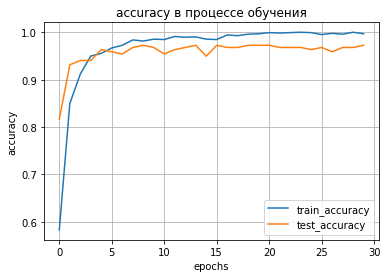

In [5]:
plt.figure()
plt.plot(history['accuracy'], label='train_accuracy')
plt.plot(history['val_accuracy'], label='test_accuracy')
plt.legend()
plt.title('accuracy в процессе обучения')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

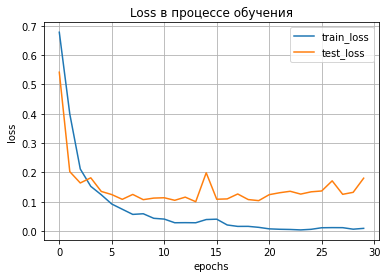

In [6]:
plt.figure()
plt.plot(history['loss'], label='train_loss')
plt.plot(history['val_loss'], label='test_loss')
plt.legend()
plt.title('Loss в процессе обучения')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()